In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Image Augmentation

In [2]:
url = "dataset-out"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(url + '/train', 
                                              class_mode='sparse',
                                              batch_size = batch_size,
                                              target_size=img_size,)

val_set = test_datagen.flow_from_directory(url + '/val',
                                           class_mode='sparse',
                                           batch_size = batch_size,
                                           target_size=img_size,)

test_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 276 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


In [3]:
class_to_index = train_set.class_indices
index_to_class = {v: k for k, v in class_to_index.items()}

print(class_to_index)
print(index_to_class)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'organic', 4: 'paper', 5: 'plastic', 6: 'trash'}


## Base Model

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(128,128,3)),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model1.summary()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=2)
checkpoint = keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=val_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [4]:
baseModel = keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False)

for layers in baseModel.layers:
    layers.trainable=False

In [5]:
model = keras.models.Sequential([
    baseModel,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy')
checkpoint = keras.callbacks.ModelCheckpoint('waste_clf_v2', monitor='val_accuracy', save_best_only=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 128)               2621568   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                        

In [ ]:
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[early_stopping, checkpoint])

#### Training process evaluating

In [18]:
model = keras.models.load_model('./waste_clf_v2')

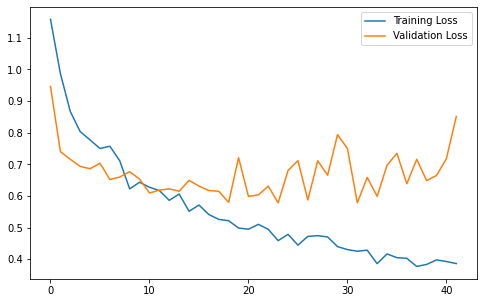

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

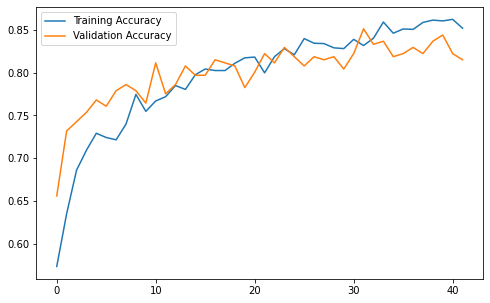

In [10]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

## Validation Test

In [11]:
train_set = test_datagen.flow_from_directory(url + '/train',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

val_set   = test_datagen.flow_from_directory(url + '/val',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 276 images belonging to 7 classes.


### Train Loss vs Validation Loss

In [12]:
print("Training loss - Accuracy")
model.evaluate(train_set)
print("Validation loss - Accuracy")
model.evaluate(val_set)
print()

Training loss - Accuracy
35/35 [==============================] - 15s 406ms/step - loss: 0.2014 - accuracy: 0.9338
Validation loss - Accuracy
5/5 [==============================] - 2s 333ms/step - loss: 0.5783 - accuracy: 0.8514



### Precision, Recall, F1-score, and Confusion Matrix

In [13]:
target_names = list(test_set.class_indices.keys())

def evaluate(y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(y, y_pred)

    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    cmp.plot(ax=ax, cmap='Blues')
    fig.show()

    print(classification_report(y, y_pred, digits=5, target_names=target_names))

#### Train set

35/35 [==============================] - 15s 400ms/step
              precision    recall  f1-score   support

   cardboard    0.95719   0.97205   0.96456       322
       glass    0.91272   0.91500   0.91386       400
       metal    0.91279   0.95732   0.93452       328
     organic    0.99495   0.98500   0.98995       200
       paper    0.92415   0.97474   0.94877       475
     plastic    0.95614   0.84935   0.89959       385
       trash    0.86792   0.84404   0.85581       109

    accuracy                        0.93375      2219
   macro avg    0.93227   0.92821   0.92958      2219
weighted avg    0.93437   0.93375   0.93327      2219



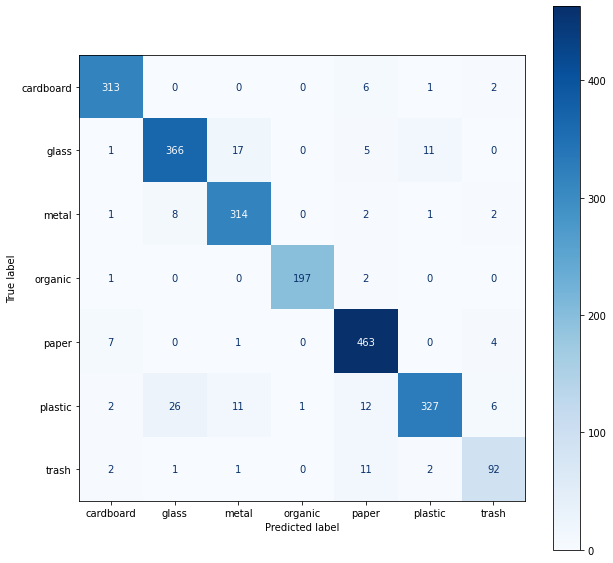

In [14]:
y = train_set.labels
y_pred = np.argmax(model.predict(train_set), axis=1)
evaluate(y, y_pred)

#### Validation set

5/5 [==============================] - 2s 331ms/step
              precision    recall  f1-score   support

   cardboard    0.87805   0.90000   0.88889        40
       glass    0.78947   0.90000   0.84112        50
       metal    0.82051   0.78049   0.80000        41
     organic    1.00000   0.96000   0.97959        25
       paper    0.80303   0.89831   0.84800        59
     plastic    0.92105   0.72917   0.81395        48
       trash    0.90909   0.76923   0.83333        13

    accuracy                        0.85145       276
   macro avg    0.87446   0.84817   0.85784       276
weighted avg    0.85741   0.85145   0.85086       276



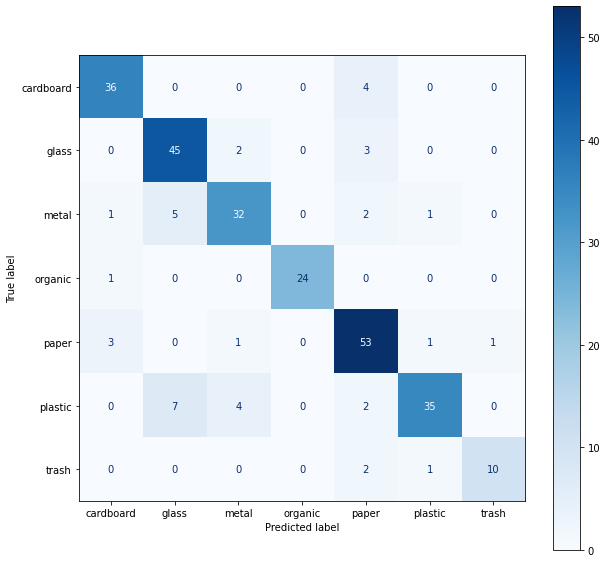

In [15]:
y = val_set.labels
y_pred = np.argmax(model.predict(val_set), axis=1)
evaluate(y, y_pred)

## Final Evaluation on Test set

### Classification Report and Confusion Matrix

5/5 [==============================] - 2s 362ms/step
              precision    recall  f1-score   support

   cardboard    0.87805   0.87805   0.87805        41
       glass    0.82353   0.82353   0.82353        51
       metal    0.84091   0.90244   0.87059        41
     organic    1.00000   0.96154   0.98039        26
       paper    0.78462   0.85000   0.81600        60
     plastic    0.87500   0.71429   0.78652        49
       trash    0.58824   0.66667   0.62500        15

    accuracy                        0.83392       283
   macro avg    0.82719   0.82807   0.82573       283
weighted avg    0.83835   0.83392   0.83413       283



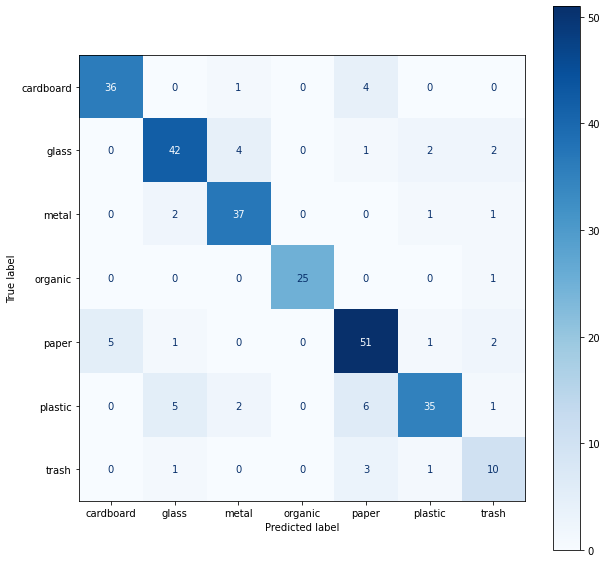

In [16]:
y = test_set.labels
y_pred = np.argmax(model.predict(test_set), axis=1)
evaluate(y, y_pred)

### Random Sample Test

In [17]:
def test():
    batch = np.random.randint(0, len(test_set)-1)
    data = 0
    img = np.random.randint(0, len(test_set[batch][data])-1)
    IMAG = test_set[batch][data][img]

    plt.imshow(IMAG)
    plt.show()
    pred = model.predict(IMAG.reshape(1, 128, 128, 3))
    probability = pred.max()
    index = np.argmax(pred)
    label = index_to_class.get(index)
    print(f"Model predicts {label.capitalize()} with probability {probability}")
    

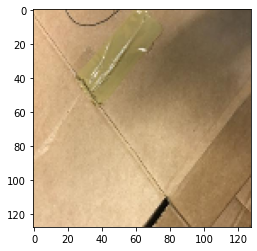

1/1 [==============================] - 1s 1s/step
Model predicts Cardboard with probability 0.9999979734420776


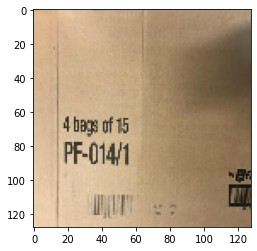

1/1 [==============================] - 0s 35ms/step
Model predicts Cardboard with probability 0.9999998807907104


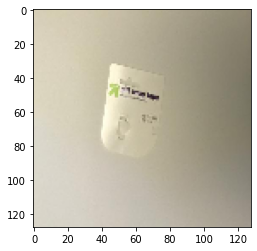

1/1 [==============================] - 0s 36ms/step
Model predicts Paper with probability 0.9980442523956299


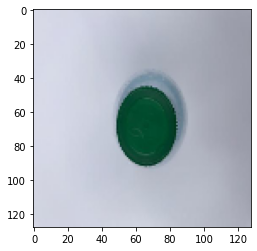

1/1 [==============================] - 0s 31ms/step
Model predicts Plastic with probability 0.9820706844329834


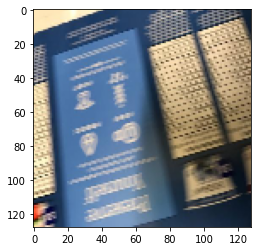

1/1 [==============================] - 0s 58ms/step
Model predicts Paper with probability 0.7902613878250122


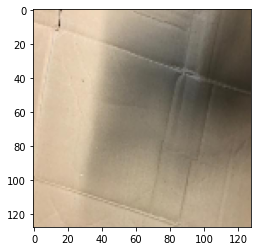

1/1 [==============================] - 0s 33ms/step
Model predicts Cardboard with probability 1.0


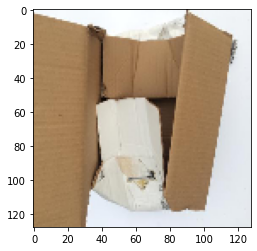

1/1 [==============================] - 0s 32ms/step
Model predicts Cardboard with probability 0.9999644756317139


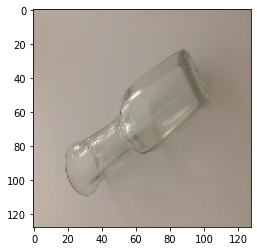

1/1 [==============================] - 0s 37ms/step
Model predicts Glass with probability 0.9842253923416138


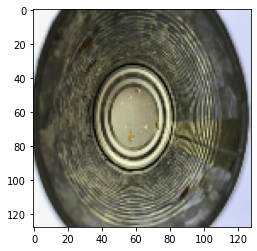

1/1 [==============================] - 0s 33ms/step
Model predicts Metal with probability 0.9991260170936584


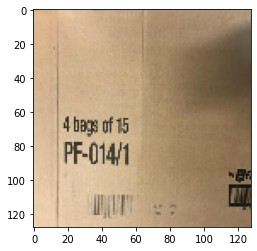

1/1 [==============================] - 0s 34ms/step
Model predicts Cardboard with probability 0.9999998807907104


In [20]:
for i in range(10):
    test()

## Save model

In [21]:
model.save("waste_classifier_v2")

INFO:tensorflow:Assets written to: waste_classifier_v2\assets


INFO:tensorflow:Assets written to: waste_classifier_v2\assets
